In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# TODO Replace BASE_URL with your own
URMIL_BASE_URL = "/content/drive/MyDrive/APS360/APS360 Project/Dataset"
HIMANISH_BASE_URL = "/content/drive/MyDrive/UofT Third Year /APS 360/Project/APS360 Project/Dataset"
SAMREEN_BASE_URL = "/content/drive/MyDrive/APS360 Project/Dataset"
MIHIKA_BASE_URL = "/content/drive/MyDrive/3: third year/APS360/APS360 Project/Dataset"

BASE_URL = HIMANISH_BASE_URL

In [ ]:
!pip install pydub==0.25.1
!pip install librosa
!pip install keras

In [ ]:
import numpy as np
from numpy import array
from numpy import argmax
from tensorflow.keras.utils import to_categorical
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os
import matplotlib.pyplot as plt
from pydub import AudioSegment
import math
from collections import Counter
from enum import Enum
import librosa
import librosa.display
import pickle
import random
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import sklearn
from sklearn import preprocessing
import seaborn as sns
from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, 
                          Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout, GlobalAveragePooling2D)
from keras.models import Sequential
from keras.layers import PReLU
from keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers
from keras.initializers import Constant
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score

random.seed(0)
np.random.seed(12)
torch.manual_seed(12)

In [ ]:
class Genre(Enum):
  BLUES = 0
  CLASSICAL = 1
  COUNTRY = 2
  DISCO = 3
  HIPHOP = 4
  JAZZ = 5
  METAL = 6
  POP = 7
  REGGAE = 8
  ROCK = 9

In [ ]:
label_train = []
label_valid = []
label_test = []

mfcc_train, mfcc_valid, mfcc_test = [], [], []

# Split Files into Test, Valid and Training
def split_pkl_data(genre):
  with open(f"{BASE_URL}/processed_pkl/{genre}/mfcc.pkl", 'rb') as infile:
      data = pickle.load(infile)
  random.shuffle(data)

  train = data[:700]
  temp = [genre]*700
  label_train.extend(temp)
  valid = data[700:700+150]
  temp = [genre]*150
  label_valid.extend(temp)
  test = data[700+150:]
  temp = [genre]*(len(data[700+150:]))
  label_test.extend(temp)

  mfcc_train.extend(train)
  mfcc_valid.extend(valid)
  mfcc_test.extend(test)

for i in Genre:
  print('Processing', i.name.lower())
  split_pkl_data(i.name.lower())

label_train = to_categorical(array([Genre[i.upper()].value for i in label_train]))
label_valid = to_categorical(array([Genre[i.upper()].value for i in label_valid]))
label_test = to_categorical(array([Genre[i.upper()].value for i in label_test]))

mfcc_train = np.array(mfcc_train)
mfcc_valid = np.array(mfcc_valid)
mfcc_test = np.array(mfcc_test)

input_shape = (mfcc_train.shape[1] * mfcc_train.shape[2], 1)
print(input_shape)

mfcc_train = mfcc_train.reshape(mfcc_train.shape[0], mfcc_train.shape[1]* mfcc_train.shape[2])
mfcc_train = preprocessing.normalize(mfcc_train)
mfcc_train = mfcc_train.reshape(mfcc_train.shape[0], mfcc_train.shape[1], 1)
print(mfcc_train.shape)

mfcc_valid = mfcc_valid.reshape(mfcc_valid.shape[0], mfcc_valid.shape[1]* mfcc_valid.shape[2])
mfcc_valid = preprocessing.normalize(mfcc_valid)
mfcc_valid = mfcc_valid.reshape(mfcc_valid.shape[0], mfcc_valid.shape[1], 1)
print(mfcc_valid.shape)
mfcc_test = mfcc_test.reshape(mfcc_test.shape[0], mfcc_test.shape[1]*mfcc_test.shape[2], 1)
print(mfcc_test.shape)

Processing blues
Processing classical
Processing country
Processing disco
Processing hiphop
Processing jazz
Processing metal
Processing pop
Processing reggae
Processing rock
(1690, 1)
(7000, 1690, 1)
(1500, 1690, 1)
(1481, 1690, 1)


In [ ]:
print(label_train[1].shape)

In [ ]:
def build_model(input_shape):
  model = Sequential([
    Dense(128,input_dim=13*130, activation='relu'),
    #LeakyReLU(alpha=0.3),
    Dense(64, activation='relu'),
    #LeakyReLU(alpha=0.3), # PReLU(alpha_initializer=Constant(value=0.25)),
    #LeakyReLU(alpha=0.3),
    Dense(10, activation='softmax')       
  ])

  return model

def train_model(model, input_shape, lr=0.01, batch_size=32, epochs=80):
  optimizer = optimizers.Adam(learning_rate=lr)
  model.build(input_shape)
  model.compile(loss='categorical_crossentropy', 
      optimizer=optimizer,
      metrics=['acc'])

  model.summary()
  
  history = model.fit(mfcc_train, label_train, epochs=epochs, validation_data=(mfcc_valid, label_valid), batch_size=batch_size)

  return history

def plt_model_training(history):
  # Displaying loss values
  plt.figure(figsize=(8,8))
  plt.title('Loss Value')
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['loss', 'val_loss'])
  print('loss:', history.history['loss'][-1])
  print('val_loss:', history.history['val_loss'][-1])
  plt.show()

  # Displaying accuracy scores
  plt.figure(figsize=(8,8))
  plt.title('Accuracy')
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.legend(['acc', 'val_acc'])
  print('acc:', history.history['acc'][-1])
  print('val_acc:', history.history['val_acc'][-1])
  plt.show()

def eval_model(model):
  for i in [(mfcc_train, label_train, 'train'),
            (mfcc_valid, label_valid, 'valid'),
            (mfcc_test, label_test, 'test')]:
    _, acc = model.evaluate(i[0], i[1], verbose=0)
    print(f"{i[2].title()} accuracy: {acc}")

def predict_model(model, data=mfcc_test.reshape(mfcc_test.shape[0], mfcc_test.shape[1], mfcc_test.shape[2]), labels=label_test):
  predictions = model.predict(data)
  labels = np.argmax(labels, axis=1)
  predictions = np.argmax(predictions, axis=1)
  ans = accuracy_score(labels, predictions, normalize=True, sample_weight=None)

  return predictions, labels, ans

def cf_matrix(predictions, labels):
  
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(10,10))
  classes = [i.name for i in Genre]

  sns.heatmap(cm, annot=True, xticklabels=classes, yticklabels=classes, fmt='d', cmap=plt.cm.Blues, cbar=False)
  plt.xlabel('Predicted Label')
  plt.ylabel('Actual Label')
  plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               216448    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 225,354
Trainable params: 225,354
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
110/110 [==============================] - 3s 13ms/step - loss: 46.3940 - acc: 0.1684 - val_loss: 14.8430 - val_acc: 0.2100
Epoch 2/50
110/110 [==============================] - 1s 10ms/step - loss: 12.8010 - acc: 0.2249 - val_loss: 12.4379 - val_acc: 0.2280
Epoch 3/50
110/110 [========================

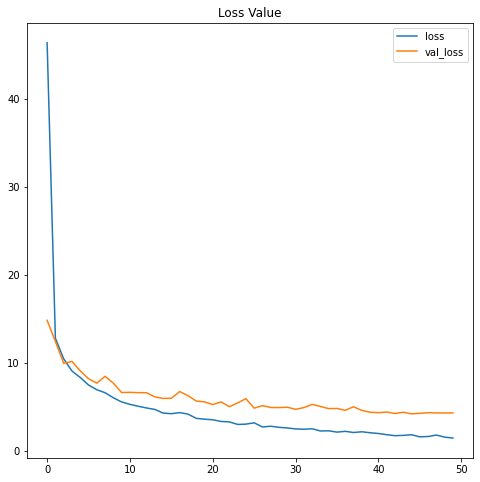

acc: 0.6078571677207947
val_acc: 0.3386666774749756


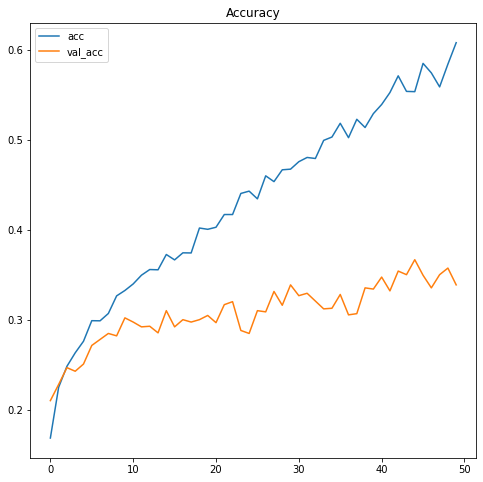

Train accuracy: 0.6091428399085999
Valid accuracy: 0.3386666774749756
Test accuracy: 0.3234301209449768


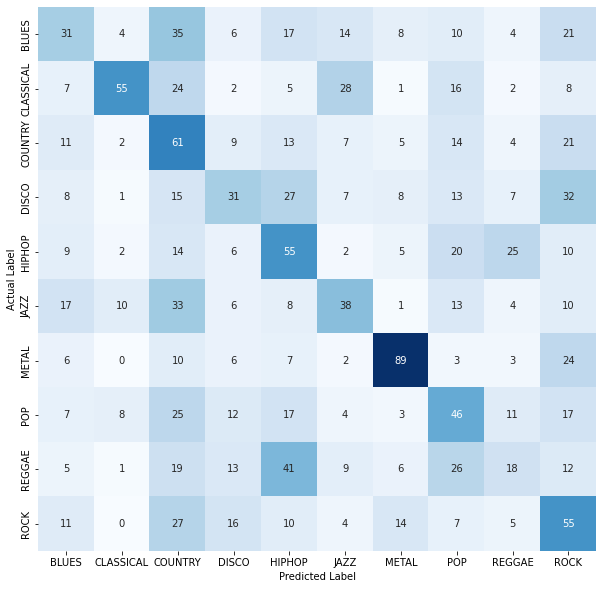

In [ ]:
# Testing out the baseline model
model = build_model(input_shape)
history = train_model(model, input_shape, 0.0001, 64, 50)
plt_model_training(history)
eval_model(model)
predictions, labels, _ = predict_model(model)
cf_matrix(predictions, labels)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               216448    
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 10)                650       
                                                                 
Total params: 225,354
Trainable params: 225,354
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
110/110 [==============================] - 2s 14ms/step - loss: 49.3638 - acc: 0.1711 - val_loss: 16.9795 - val_acc: 0.2233
Epoch 2/100
110/110 [==============================] - 1s 13ms/step - loss: 14.7242 - acc: 0.2351 - val_loss: 14.3105 - val_acc: 0.2553
Epoch 3/100
110/110 [===================

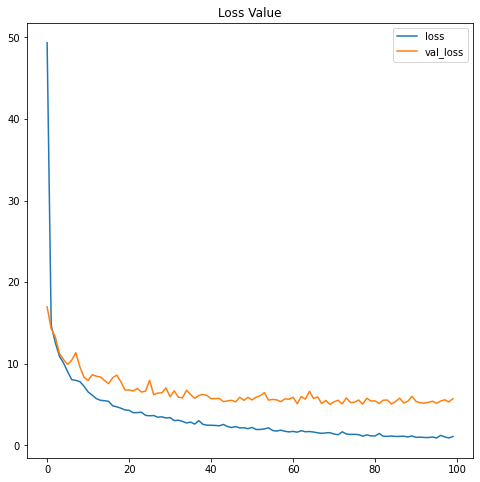

acc: 0.7032856941223145
val_acc: 0.35466668009757996


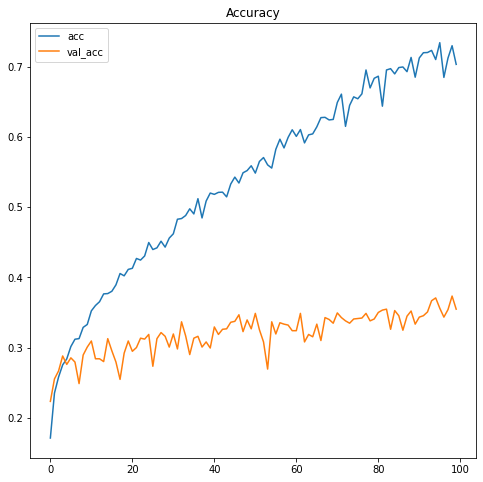

Train accuracy: 0.680142879486084
Valid accuracy: 0.35466668009757996
Test accuracy: 0.3389601707458496


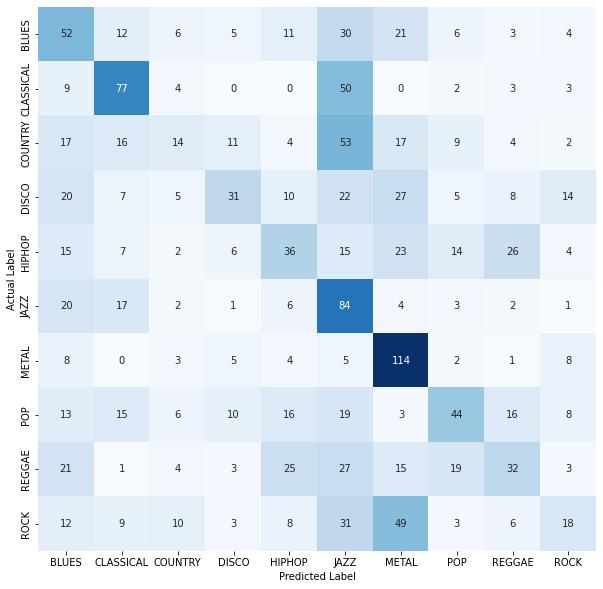

In [ ]:
# Testing out the baseline model
model1 = build_model(input_shape)
history = train_model(model1, input_shape, 0.0001, 64, 100)
plt_model_training(history)
eval_model(model1)
predictions, labels, _ = predict_model(model1)
cf_matrix(predictions, labels)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 256)               432896    
                                                                 
 p_re_lu (PReLU)             (None, 256)               256       
                                                                 
 dense_21 (Dense)            (None, 128)               32896     
                                                                 
 p_re_lu_1 (PReLU)           (None, 128)               128       
                                                                 
 dense_22 (Dense)            (None, 30)                3870      
                                                                 
 p_re_lu_2 (PReLU)           (None, 30)                30        
                                                                 
 dense_23 (Dense)            (None, 10)               

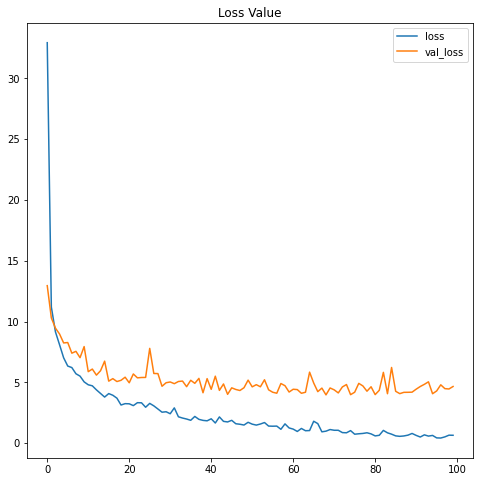

acc: 0.8047142624855042
val_acc: 0.38866665959358215


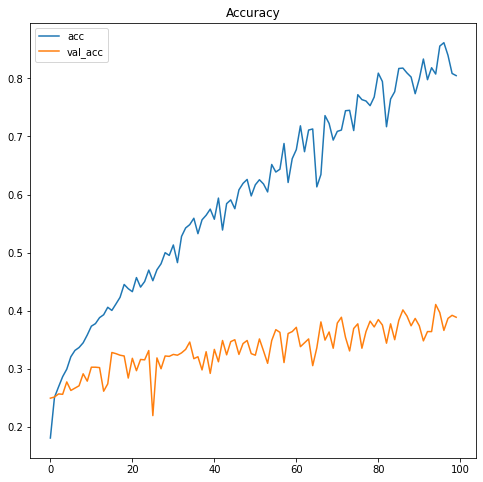

Train accuracy: 0.8272857069969177
Valid accuracy: 0.38866665959358215
Test accuracy: 0.3652937114238739


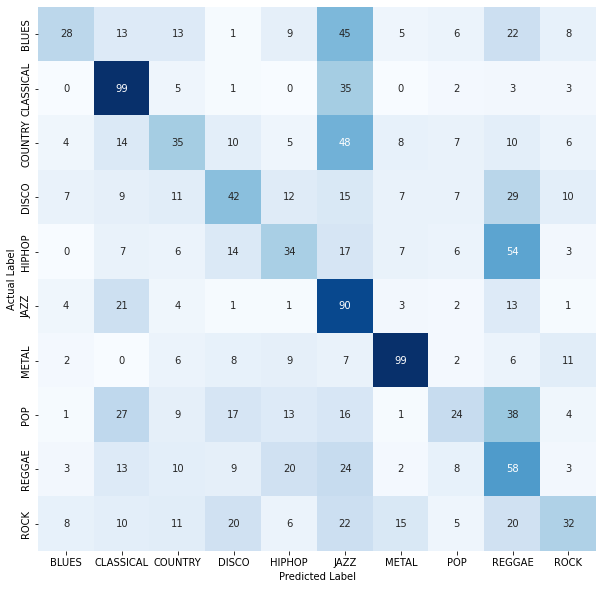

In [ ]:
# Testing out the baseline model (with prelu and modified layers)
model2 = build_model(input_shape)
history = train_model(model2, input_shape, 0.0001, 64, 100)
plt_model_training(history)
eval_model(model2)
predictions, labels, _ = predict_model(model2)
cf_matrix(predictions, labels)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 128)               216448    
                                                                 
 dense_79 (Dense)            (None, 64)                8256      
                                                                 
 dense_80 (Dense)            (None, 10)                650       
                                                                 
Total params: 225,354
Trainable params: 225,354
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
219/219 [==============================] - 2s 6ms/step - loss: 2.2723 - acc: 0.1966 - val_loss: 2.2053 - val_acc: 0.2787
Epoch 2/100
219/219 [==============================] - 1s 5ms/step - loss: 2.0861 - acc: 0.2817 - val_loss: 1.9782 - val_acc: 0.2847
Epoch 3/100
219/219 [========================

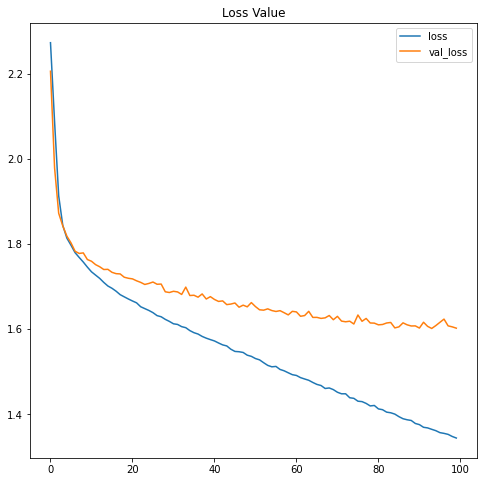

acc: 0.5314285755157471
val_acc: 0.4233333468437195


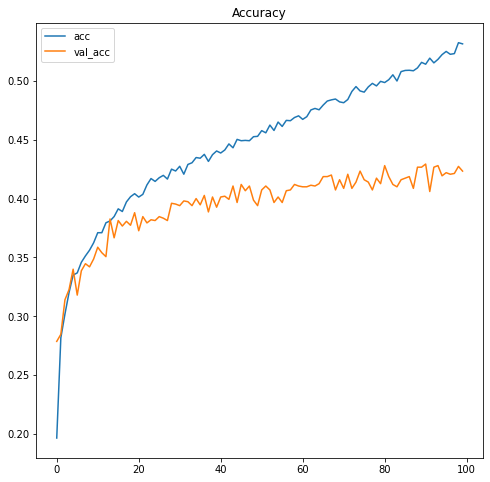

Train accuracy: 0.5364285707473755
Valid accuracy: 0.4233333468437195
Test accuracy: 0.4152599573135376


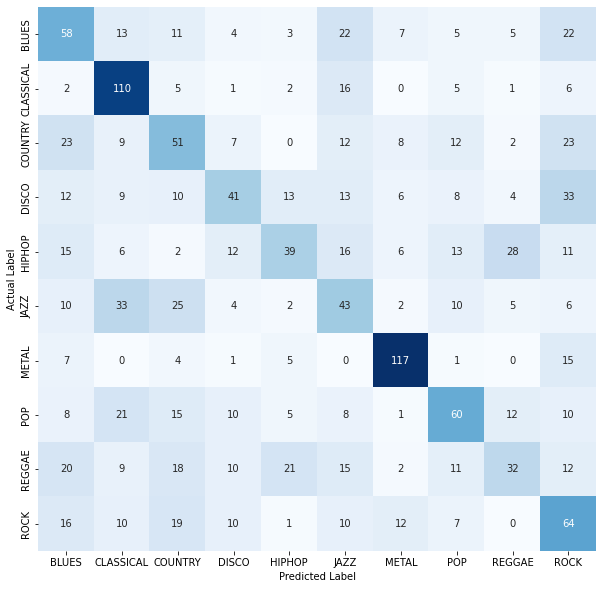

In [ ]:
# Testing out the baseline model
model3 = build_model(input_shape)
history = train_model(model3, input_shape, 0.0003, 32, 100)
plt_model_training(history)
eval_model(model3)
predictions, labels, _ = predict_model(model3)
cf_matrix(predictions, labels)